# ⭐🐟 GBR Prediction ⭐🐟
### By [Luca Ordronneau](https://www.kaggle.com/lucaordronneau)
# 📚 Import Librairies

In [1]:
import os
import sys
import ast
import time
import torch
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import cv2
from PIL import Image
from IPython.display import display

# 📂 Variables

In [2]:
IMG_SIZE  = 5200
AUGMENT   = True
IOU       = 0.4
CONF      = 0.2

# 📌 Help functions

In [3]:
def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y2]
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes

def coco2voc(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes_yolo = coco2yolo(bboxes, image_height, image_width)
    bboxes_voc = yolo2voc(bboxes_yolo, image_height, image_width)
    return bboxes_voc

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [4]:
def load_model(model_path, conf=0.35, iou=0.50):
    model = torch.hub.load('/kaggle/input/yolov5','custom', path=model_path, source='local', force_reload=True)
    model.conf = conf
    model.iou  = iou
    model.classes = None
    model.multi_label = False
    model.max_det = 1000
    return model

In [5]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values # voc format
    if len(bboxes):
        bboxes  = voc2coco(bboxes, height, width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [], []

In [6]:
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf:.2f} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

In [7]:
def draw_yolox_predictions(img, bboxes, scores, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = 0
            score = scores[i]

            x0 = int(box[0])
            y0 = int(box[1])
            x1 = int(box[0]) + int(box[2])
            y1 = int(box[1]) + int(box[3])

            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

In [8]:
!cp -r /kaggle/input/yolov5 /kaggle/working

In [9]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/fontarialyolov5/Arial.ttf /root/.config/Ultralytics/

In [10]:
model_path = "/kaggle/input/v53-l-s2-t640-v1280-sbsq-02-e16-b6-s1280/V53-L-S2-T640-V1280-SbSq-0.2-E16-B6-S1280.pt"

model = load_model(model_path, conf=CONF, iou=IOU)

# 🔍 Prediction

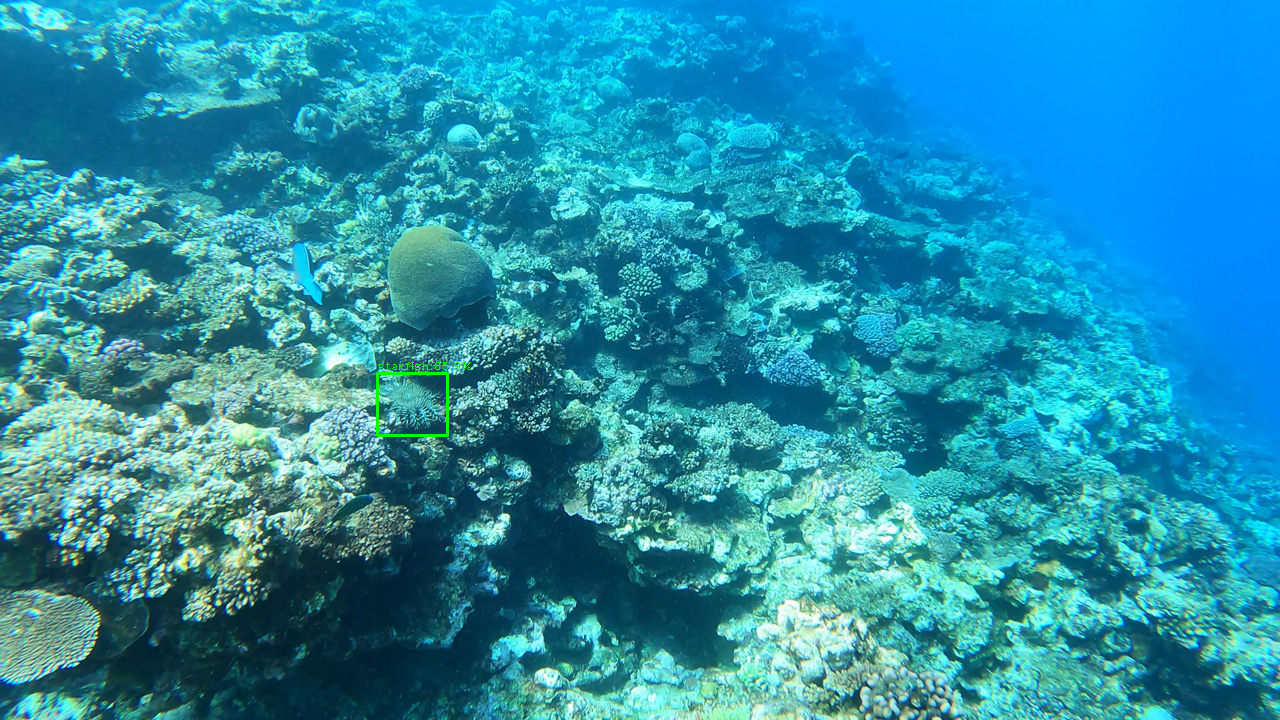

In [11]:
COCO_CLASSES = (
  "starfish",
)

TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0/84.jpg"

img = cv2.imread(TEST_IMAGE_PATH)
bboxes, scores = predict(model, img, IMG_SIZE, AUGMENT)

out_image = draw_yolox_predictions(img, bboxes, scores, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

In [12]:
test = np.load("/kaggle/input/tensorflow-great-barrier-reef/example_test.npy")

for img in test:
    bboxes, confs = predict(model, img, IMG_SIZE, AUGMENT)
    annot         = format_prediction(bboxes, confs)
    print('Prediction:', annot)

Prediction: 0.33 242 133 56 31
Prediction: 0.44 238 133 59 31
Prediction: 0.21 234 134 57 32


In [13]:
import greatbarrierreef
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

In [14]:
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs = predict(model, img, IMG_SIZE, AUGMENT)
    annot = format_prediction(bboxes, confs)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    print('Prediction:', annot)

0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Prediction: 0.33 242 133 56 31
Prediction: 0.44 238 133 59 31
Prediction: 0.21 234 134 57 32
